In [1]:
import torch
import pandas as pd
import os
from torchvision import transforms
from EmotionDataset import EmotionDataset, get_transform
from EmotionCNN import EmotionCNN
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomAdjustSharpness,
    ToTensor
)

In [2]:
# Load and prepare the dataset
dataset_path = os.path.join(os.getcwd(), 'data')
labels_path = os.path.join(dataset_path, 'labels.csv')
df = pd.read_csv(labels_path)

df['label'] = df['pth'].apply(lambda x: x.split('/')[0])
df['pth'] = df['pth'].apply(lambda x: os.path.join(dataset_path, x))
one_hot_encoded_df = pd.get_dummies(df['label']).astype(int)
df = pd.concat([df.drop('label', axis=1), one_hot_encoded_df], axis=1)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['relFCs'], inplace=True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
# Transform for first epoch
transform_initial = get_transform()

# Augment training data for epochs after first
transform_augmented = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    RandomAdjustSharpness(2),
    transforms.Resize((96, 96)),
    ToTensor()
])

In [4]:
# Create the datasets
train_dataset = EmotionDataset(train_df, transform_initial)
test_dataset = EmotionDataset(test_df, get_transform())

In [5]:
# Set up the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [6]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, 1)
    _, labels = torch.max(labels, 1)
    return (predictions == labels).float().mean().item()

In [8]:
# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Update the transform after the first epoch
    if epoch > 0:
        train_dataset.transform = transform_augmented
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Save training loss
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluate on training set
    model.eval()
    train_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_accuracy += calculate_accuracy(outputs, labels)
    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on testing set
    test_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy += calculate_accuracy(outputs, labels)
    test_accuracy /= len(test_loader)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracies[-1]:.4f}, Testing Accuracy: {test_accuracies[-1]:.4f}')

Epoch [1/10], Loss: 0.2850, Training Accuracy: 0.5508, Testing Accuracy: 0.5293
Epoch [2/10], Loss: 0.2319, Training Accuracy: 0.5872, Testing Accuracy: 0.5760
Epoch [3/10], Loss: 0.2165, Training Accuracy: 0.6253, Testing Accuracy: 0.6159
Epoch [4/10], Loss: 0.2055, Training Accuracy: 0.6376, Testing Accuracy: 0.6143
Epoch [5/10], Loss: 0.1980, Training Accuracy: 0.6563, Testing Accuracy: 0.6229
Epoch [6/10], Loss: 0.1919, Training Accuracy: 0.6710, Testing Accuracy: 0.6343
Epoch [7/10], Loss: 0.1865, Training Accuracy: 0.6945, Testing Accuracy: 0.6399
Epoch [8/10], Loss: 0.1805, Training Accuracy: 0.7009, Testing Accuracy: 0.6389
Epoch [9/10], Loss: 0.1759, Training Accuracy: 0.7103, Testing Accuracy: 0.6540
Epoch [10/10], Loss: 0.1716, Training Accuracy: 0.7184, Testing Accuracy: 0.6442


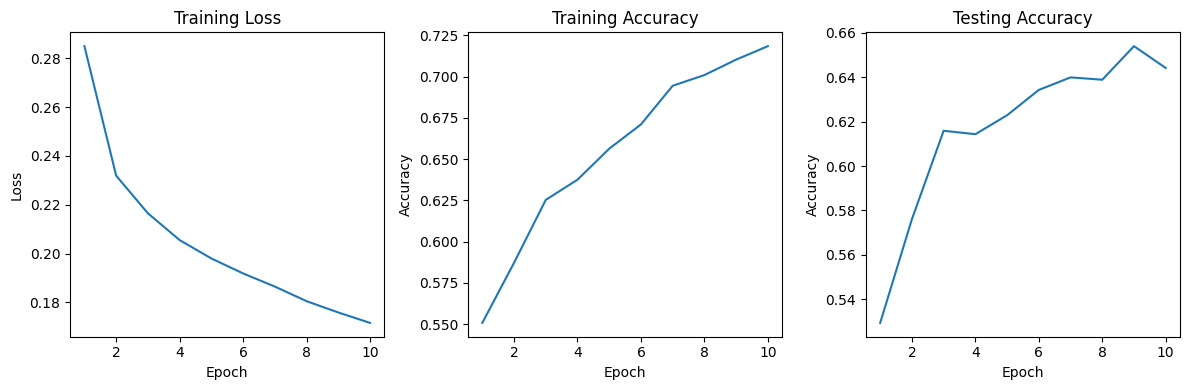

In [9]:
# Plot model evaluation
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies)
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [10]:
# Save model
torch.save(model, './models/emotionModel3')

In [11]:
# Load model
model_path = './models/emotionModel1'
model = torch.load(model_path)